# Linear regression

This tutorial provides a basic example of several calibration procedures using a linear regression model.

# Imports

We will first import all required dependencies.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from calisim.data_model import (
	DistributionModel,
	ParameterDataType,
	ParameterSpecification,
)
from calisim.statistics import MeanSquaredError, L2Norm

# Observed data

We will next generate the 100 observations with 5 parameters.

In [2]:
p = 5
n = 100

rng = np.random.default_rng(100)
X = rng.standard_normal(size=(n, p))

def g(beta):
    return X @ beta

beta_true = np.linspace(-1, 1, num=p)
observation_noise = rng.standard_normal(size=n)
y = g(beta_true) + observation_noise

observed_df = pd.DataFrame(X, columns = [f"x_{i}" for i in range(p)])
observed_df["y"] = y
observed_df

,x_0,x_1,x_2,x_3,x_4,y
0,-1.157550,0.289756,0.780854,0.543974,-0.961383,2.285896
1,1.071009,0.701456,0.704973,0.745063,1.104347,0.669554
2,2.242972,-0.611493,0.047211,1.754235,-1.337980,-1.459401
3,0.325574,-0.689118,-0.019822,0.474753,-1.931101,-2.094742
4,-0.992478,-1.405471,-0.231096,-0.688847,1.515106,1.770539
...,...,...,...,...,...,...
95,-1.197676,0.862309,-0.881934,1.284170,-2.485180,-2.335480
96,-0.508350,0.826742,0.845005,-1.971125,0.178238,-0.189965
97,0.159850,0.249380,-0.404957,-0.818494,0.162018,1.357254
98,0.537970,0.959307,-0.115592,-0.862106,0.699542,-2.153486


<Axes: xlabel='x_0', ylabel='y'>

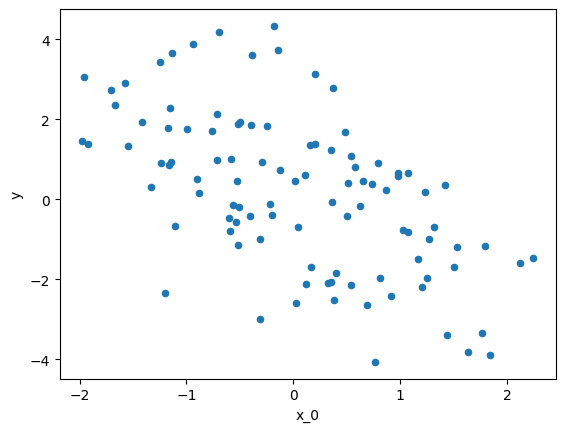

In [3]:
observed_df.plot.scatter("x_0", "y")

We aim to recover the ground truth parameters using several calibration procedures.

In [4]:
pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_value": beta_true
})

,beta_name,beta_value
0,x_0,-1.0
1,x_1,-0.5
2,x_2,0.0
3,x_3,0.5
4,x_4,1.0


# Gradient-based optimisation using least squares

[For linear regression, we can typically easily fit a model using the least squares algorithm and a gradient-based optimiser from the SciPy library.](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html) Let's start there.

In [5]:
import numpy as np
from scipy.optimize import least_squares

def residuals(beta, X, y):
    return X @ beta - y

beta_0 = np.zeros(X.shape[1])
opt_results = least_squares(residuals, beta_0, args=(X, y))

pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_estimate": opt_results.x,
    "beta_value": beta_true
})

,beta_name,beta_estimate,beta_value
0,x_0,-0.985116,-1.0
1,x_1,-0.505724,-0.5
2,x_2,0.145507,0.0
3,x_3,0.611258,0.5
4,x_4,1.048820,1.0


<Axes: xlabel='observed', ylabel='simulated'>

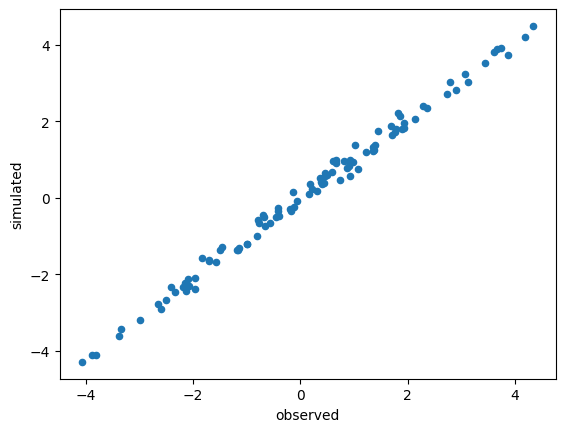

In [33]:
pd.DataFrame({
    "observed": observed_df.y.values,
    "simulated": g(opt_results.x) + observation_noise
}).plot.scatter("observed", "simulated")

We can see that the SciPy optimiser was easily able to recover the ground truth parameters.

However, suppose that you are working with a more complex scientific computer simulation model. We may not have access to the gradients of the model. Perhaps the functional form of the model is highly complex or a black-box. Moreover, we might be working with a stochastic simulation model that is heavily noisy, such as an agent-based model. Furthermore, it may take several hours or days to run the forward model just once, hence the need for parallelisation and/or surrogate modelling.

In these cases, more sophisticated calibration procedures are required such as those offered by calisim. Let's apply a sensitivity analysis, black-box optimisation, and Bayesian calibration via calisim.

# Sensitivity analysis

We will start with a Sobol sensitivity analysis to identity and quantify how the variation in the 5 input parameters of the model influences the variation in the model outputs. [A detailed explaination of the Sobol methods may be found here.](https://link.springer.com/chapter/10.1007/978-3-030-51862-2_6)

In [9]:
from calisim.sensitivity import (
	SensitivityAnalysisMethod,
	SensitivityAnalysisMethodModel,
)

We first construct the parameter specification for the Sobol sensitivity analysis. This defines the parameter ranges, distribution types, and data types.

In [11]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="x_0",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_1",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_2",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_3",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_4",
			distribution_name="uniform",
			distribution_args=[-1, 1],
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

We will define a sensitivity analysis function. In this case, we will calculate the mean squared error between the 100 simulated observations and synthetic observations generated by parameter sets sampled from the Sobol sensitivity analysis.

In [8]:
def sensitivity_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    beta_star = np.array(list(parameters.values()))
    simulated_data = g(beta_star) + observation_noise

    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

We next define the specification for the sensitivity analysis procedure.

We will use the [Sobol sensitivity analysis from the SALib library](https://salib.readthedocs.io/en/latest/), calculating both first order sensitivity indices (direct effects of each parameter) and second order sensitivity indices (interaction effects of each combination of parameters).

We'll set the base number of samples to *128* for our *5* parameters. The total number of samples taken is equal to *N * (2D + 2)*, where **N** = the base number of samples and **D** = the number of parameters. Hence, we will run the forward model, our linear regression, 1536 times.

We will use the bootstrap methods to calculate 95% confidence intervals, with 200 resamples.

 /home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


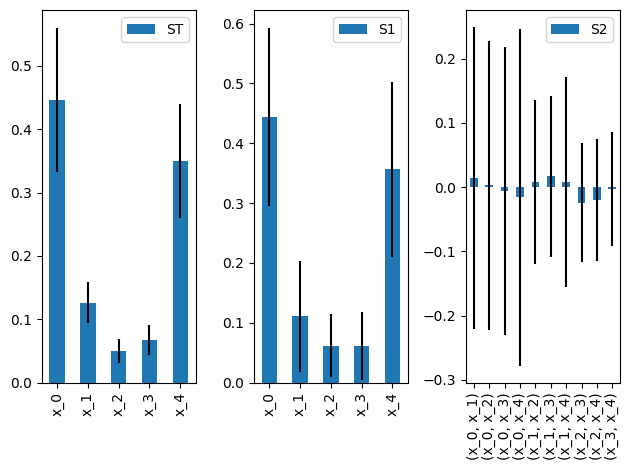

 /home/jbris/.cache/pypoetry/virtualenvs/calisim-examples-yfUJKvMn-py3.10/lib/python3.10/site-packages/SALib/util/__init__.py:274: FutureWarning:unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.


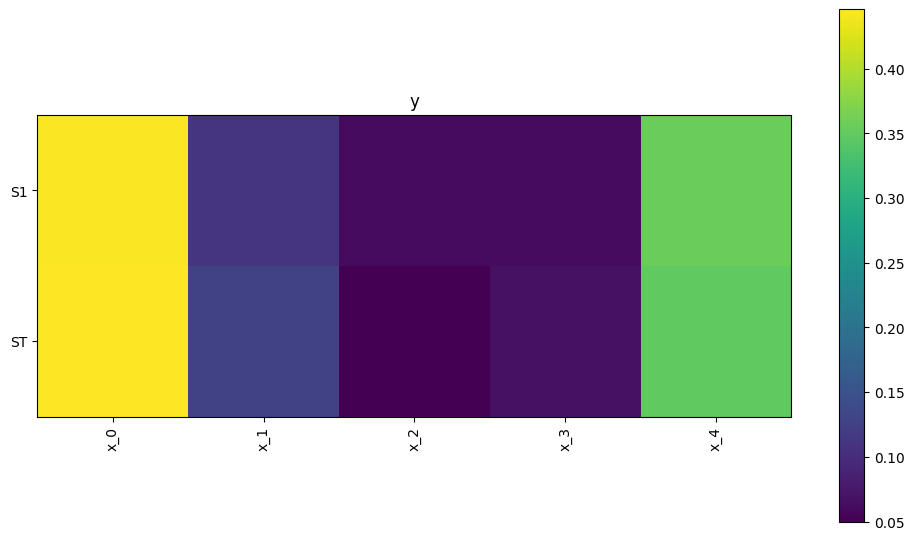

In [12]:
specification = SensitivityAnalysisMethodModel(
	experiment_name="salib_sensitivity_analysis",
	parameter_spec=parameter_spec,
	observed_data=observed_df.y.values,
	method="sobol",
	n_samples=128,
    n_jobs=1,
	output_labels=["y"],
	verbose=True,
	batched=False,
	method_kwargs=dict(calc_second_order=True, scramble=True),
	analyze_kwargs=dict(
		calc_second_order=True,
		num_resamples=200,
		conf_level=0.95,
	),
)

calibrator = SensitivityAnalysisMethod(
	calibration_func=sensitivity_func, specification=specification, engine="salib"
)

calibrator.specify().execute().analyze()

We see that our model is most sensitive to variation in x_0 and x_4. It is least sensitive to x_2.

Note that each variable is on the same scale/magnitude. Hence, our results make sense intuitively as x_0 and x_4 have the largest coefficients. Conversely, x_2 has a coefficient of 0, and so it has no weighting.

# Optimisation

We will next perform black-box optimisation to estimate the parameter values that lead to the smallest mean square error between observed and simulated data. [We will use the Covariance Matrix Adaptation Evolution Strategy (CMA-ES) method, which as a powerful evolutionary algorithm for black-box optimisation](https://cma-es.github.io/).

In [15]:
from calisim.optimisation import OptimisationMethod, OptimisationMethodModel

[WARNING 10-09 10:30:10] ax.service.utils.with_db_settings_base: Ax currently requires a sqlalchemy version below 2.0. This will be addressed in a future release. Disabling SQL storage in Ax for now, if you would like to use SQL storage please install Ax with mysql extras via `pip install ax-platform[mysql]`.


We will reuse the parameter specification from the Sobol sensitivity analysis. One objective of calisim is to enable a modular design and modelling approach that allows users to mix-and-match different components for calibration procedures.

We will, however, define a new objective function for our optimisation. As mentioned, we will minimise the discrepancy between simulated and observed data.

In [16]:
def objective(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    beta_star = np.array(list(parameters.values()))
    simulated_data = g(beta_star) + observation_noise

    metric = MeanSquaredError()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

We further specify the parameters of our optimisation. [We will use the implementation of CMA-ES from the Optuna library to perform optimisation](https://optuna.org/).

We will run 200 optimisation trials, and treat this task as a single objective optimisation problem. 

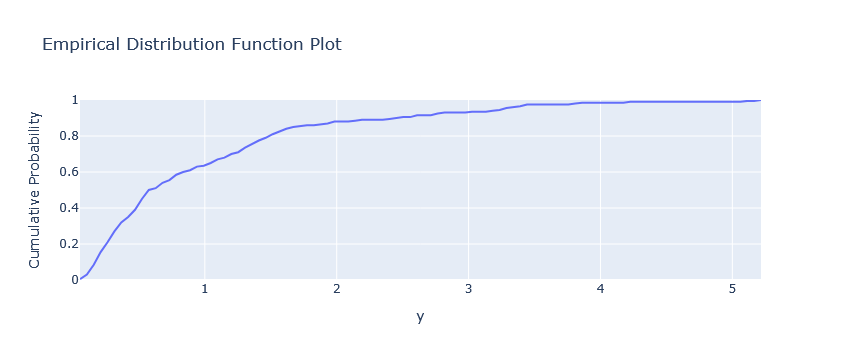

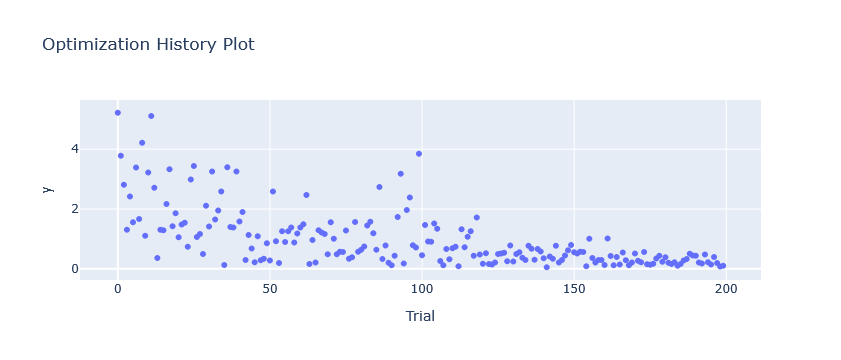

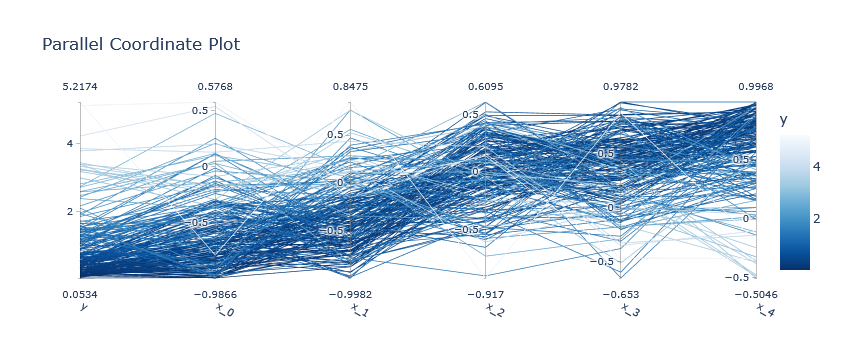

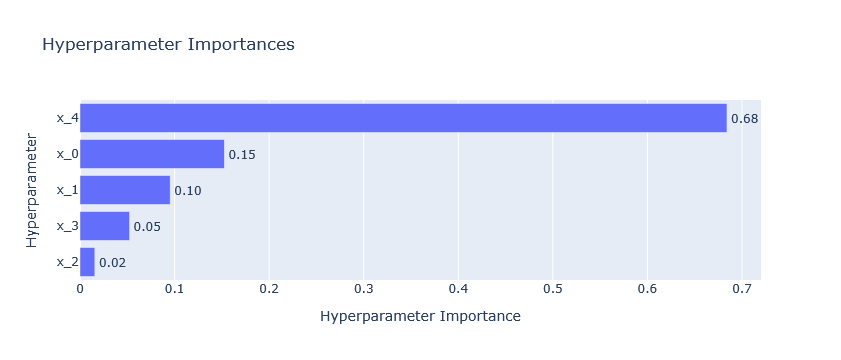

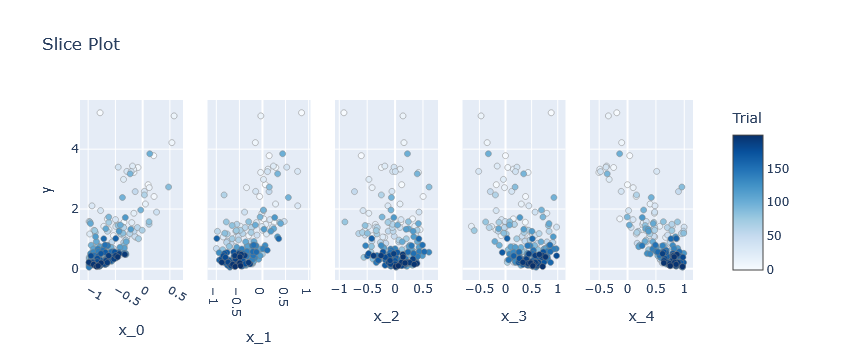

In [19]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

specification = OptimisationMethodModel(
	experiment_name="optuna_optimisation",
	parameter_spec=parameter_spec,
	observed_data=observed_df.y.values,
	method="cmaes",
	directions=["minimize"],
	output_labels=["y"],
	n_iterations=200,
    n_jobs=-1,
    verbose=False
)

calibrator = OptimisationMethod(
	calibration_func=objective, specification=specification, engine="optuna"
)
calibrator.specify().execute().analyze()

According to the cumulative probability plot, roughly 20% of the trials produced an MSE of 0.26 and below. Roughly 80% of the trials had an MSE below 1.46.

We also see that there are diminishing returns in the objective function results after 50 and 100 optimisation trials.

The parallel coordinate plot shows you the relationshio between different parameter combinations and the MSE. We see that x_0 and x1 produce the lowest MSE scores when they are around -1 and 1 respectively, while x_2 is close to 0. 

[Optuna supports the functional ANOVA (fANOVA) global sensitivity method, which is a generalisation of ANOVA](https://christophm.github.io/interpretable-ml-book/decomposition.html). While ANOVA compares differences in means for a continuous variables across different levels of one or more categorical variables, fANOVA compares differences in mean function values (i.e. the entire range of the output) attributable to each input variable/parameter. Inputs can be continuous or categorical, although fANOVA works best with continuous variables.

According to the fANOVA sensitivity analysis, the most influential parameters of the model are x_0 and x_4, while x_2 is least influential. This supports the results of the Sobol sensitivity analysis.

From the slice plots, you can see how the sampler explores the parameter space over trials to find the optimal values. Different samplers explore the parameter space in difference ways.

In [21]:
optimisation_df = pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "beta_value": beta_true
})
optimisation_df

,beta_name,beta_estimate,beta_value
0,x_0,-0.983552,-1.0
1,x_1,-0.704835,-0.5
2,x_2,0.017289,0.0
3,x_3,0.585590,0.5
4,x_4,0.970143,1.0


We are able to recover the ground-truth parameters.

# Bayesian Calibration

In some cases, we will want to return a full probability distribution of plausible parameter estimates, rather than a single point estimate. Bayesian calibration is one such approach for yielding these probabilistic estimates. Bayesian calibration is also particularly useful when working with complex, stochastic simulation models where equifinality may be present. [A useful text on Bayesian calibration may be found here](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/1467-9868.00294).

In [26]:
from calisim.abc import (
	ApproximateBayesianComputationMethod,
	ApproximateBayesianComputationMethodModel,
)

We first construct the parameter specification for Bayesian calibration. As we are going Bayesian, we can specify more complex probability distributions than the uniform distribution. In this example, we will use truncated normal distributions for our parameter specifications.

We specify both the location and scale (mean=0 and standard deviation=0.33), alongside the lower and upper bounds (lb = -1 and ub = 1) for the truncated normal distributions.

In [29]:
parameter_spec = ParameterSpecification(
	parameters=[
		DistributionModel(
			name="x_0",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_1",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_2",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_3",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
		DistributionModel(
			name="x_4",
			distribution_name="truncnorm",
			distribution_args=[-1 / 0.33, 1 / 0.33],
            distribution_kwargs=dict(loc=0, scale=0.33),
			data_type=ParameterDataType.CONTINUOUS,
		),
	]
)

Rather than using the mean squared error, ABC instead requires the use of proper distance metrics. Hence, we will use the L2 norm to quantify the discrepancy between the observed and simulated data.

In [30]:
def abc_func(
	parameters: dict, simulation_id: str, observed_data: np.ndarray | None
) -> float | list[float]:
    beta_star = np.array(list(parameters.values()))
    simulated_data = g(beta_star) + observation_noise

    metric = L2Norm()
    discrepancy = metric.calculate(observed_data, simulated_data)
    return discrepancy

[We will use Approximate Bayesian Computation (ABC) Sequential Monte Carlo to calibrate the model](https://academic.oup.com/book/54037/chapter-abstract/422208917?redirectedFrom=fulltext). ABC aims to minimise the discrepancy between observed and simulated data up to a tolerance threshold (epsilon). Larger values of epsilon will result in faster model calibration with fewer rejections of the forward model outputs but less precise estimates. Smaller values of epsilon will result in slower model calibration with more rejections of the forward model outputs but more precise estimates.

ABC.History INFO: Start <ABCSMC id=1, start_time=2025-10-09 11:50:33>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.69160335e+01.
ABC INFO: Accepted: 20 / 37 = 5.4054e-01, ESS: 2.0000e+01.
ABC.Adaptation INFO: Change nr particles 20 -> 10
ABC INFO: t: 1, eps: 1.49918219e+01.
ABC INFO: Accepted: 10 / 15 = 6.6667e-01, ESS: 6.9389e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 2, eps: 1.31932733e+01.
ABC INFO: Accepted: 10 / 21 = 4.7619e-01, ESS: 5.0914e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 3, eps: 1.22913083e+01.
ABC INFO: Accepted: 10 / 19 = 5.2632e-01, ESS: 5.5462e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 4, eps: 1.07437675e+01.
ABC INFO: Accepted: 10 / 24 = 4.1667e-01, ESS: 4.3979e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 5, eps: 9.43130756e+00.
ABC INFO: Accepted: 10 / 12 = 8.3333e-01, ESS: 3.1859e+00.
ABC.Adaptation INFO: Change nr particles 10 -> 10
ABC INFO: t: 6, e

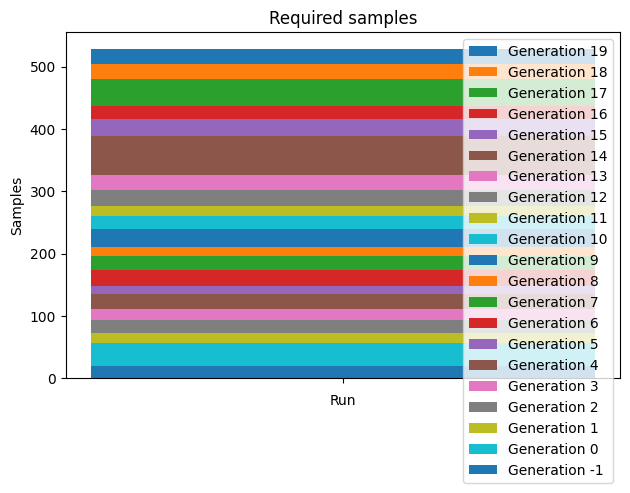

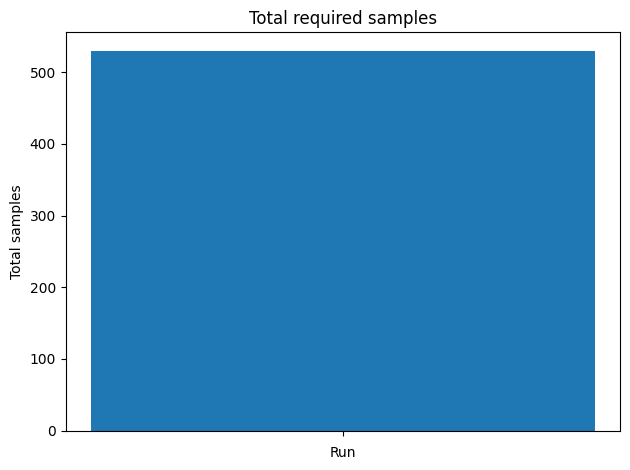

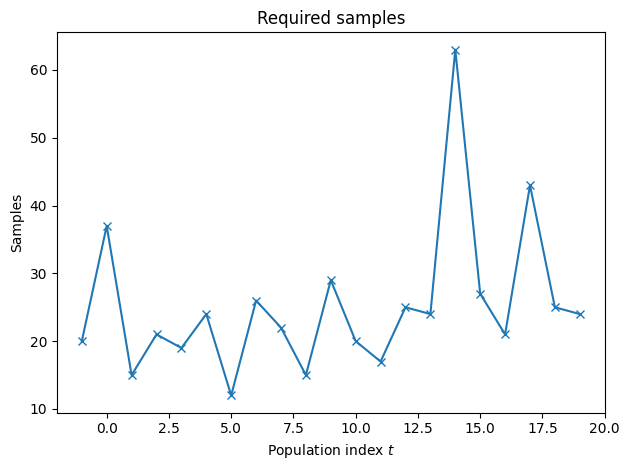

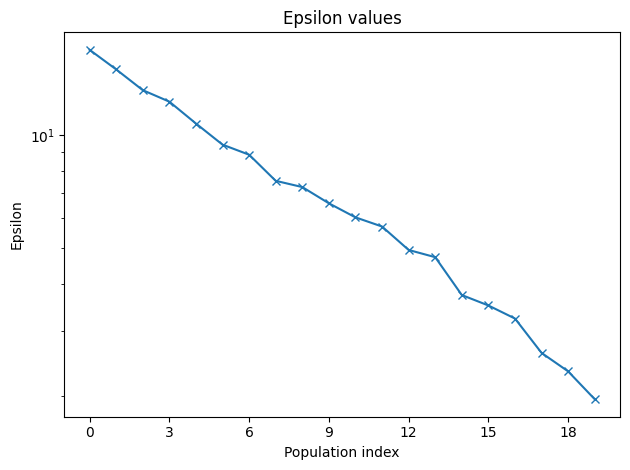

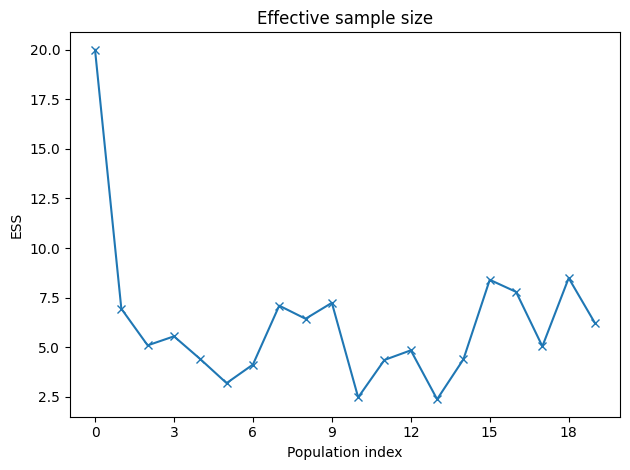

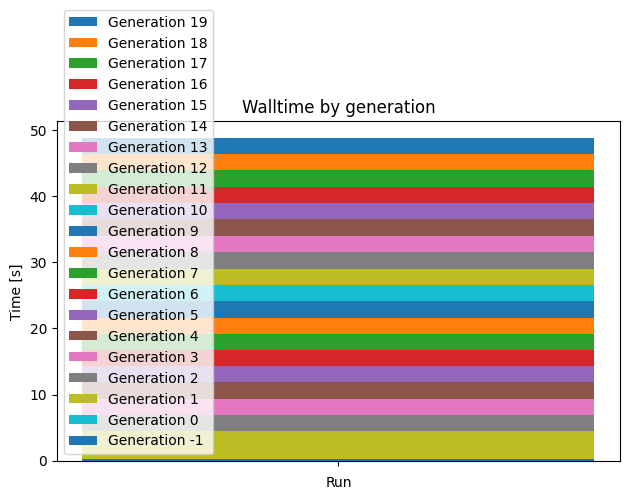

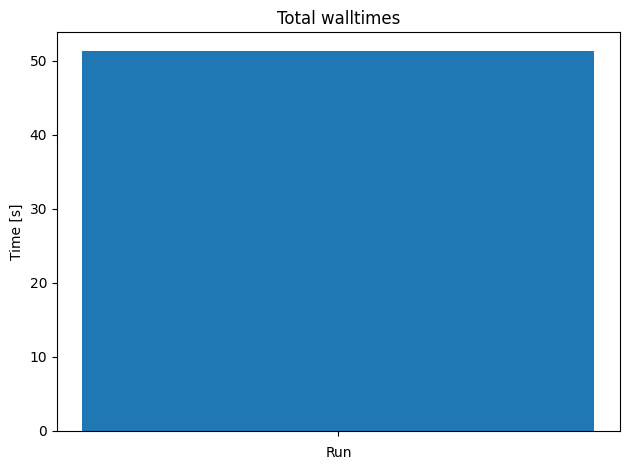

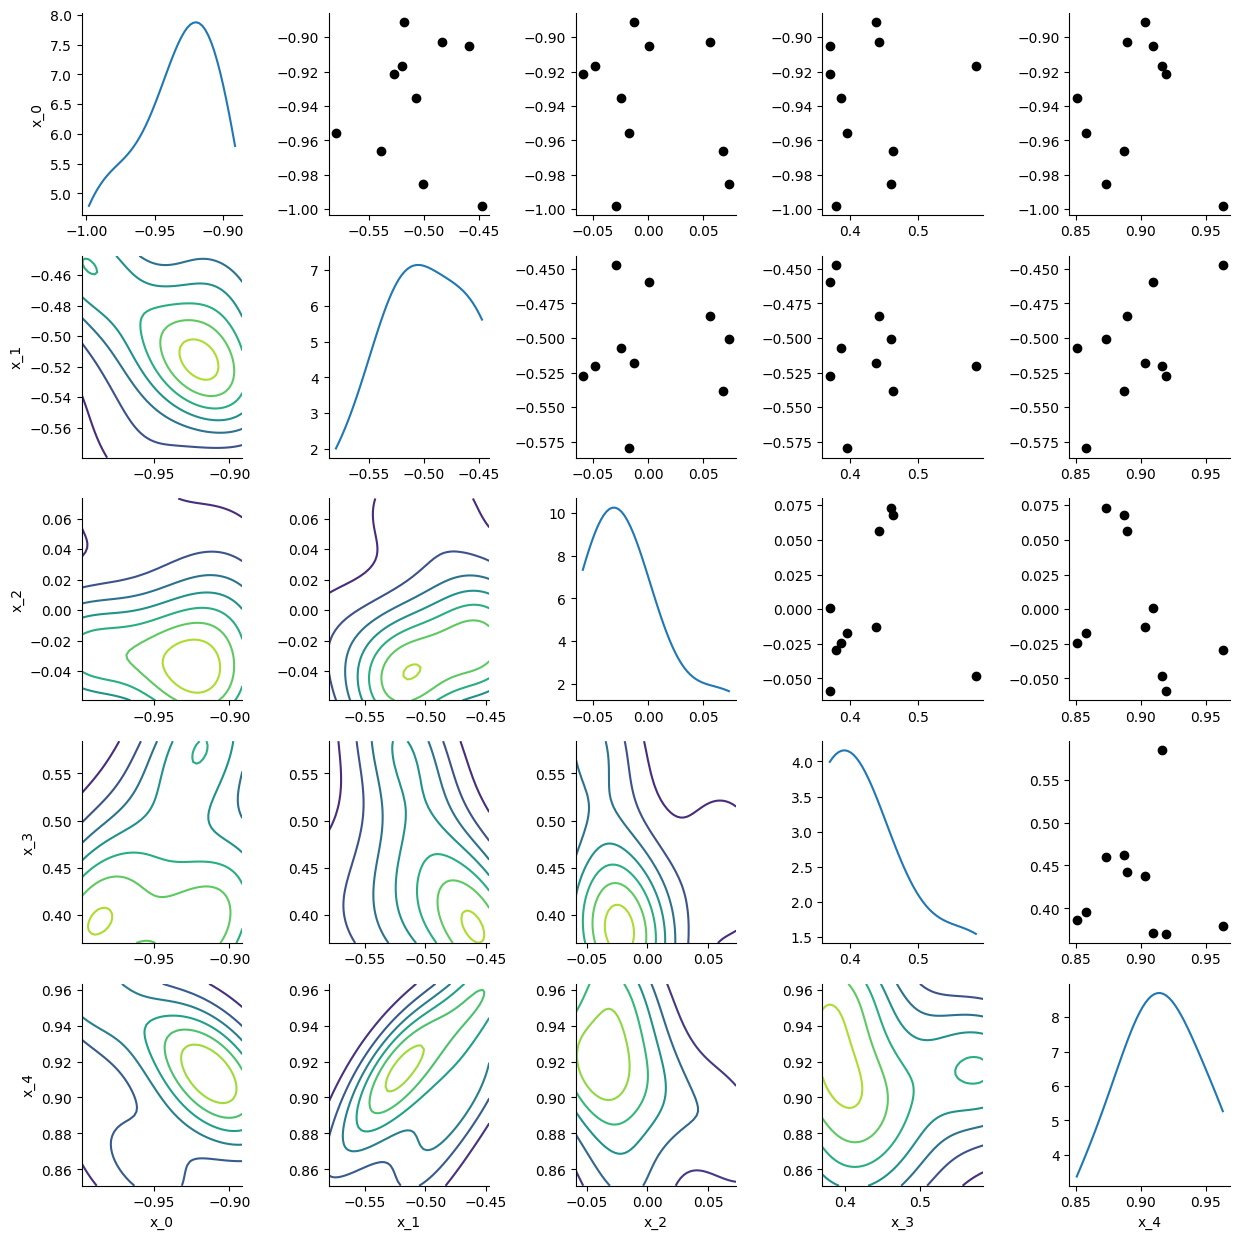

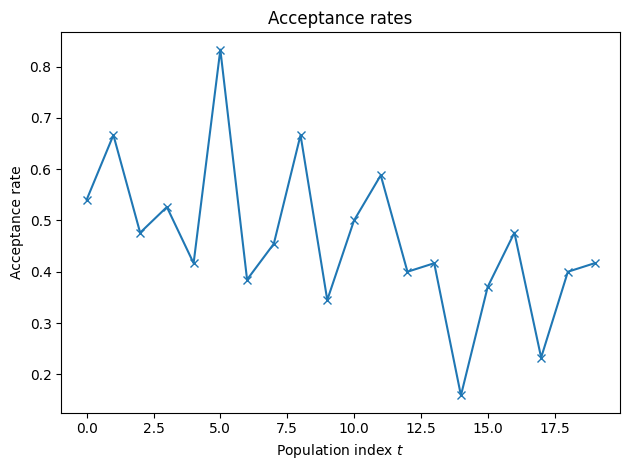

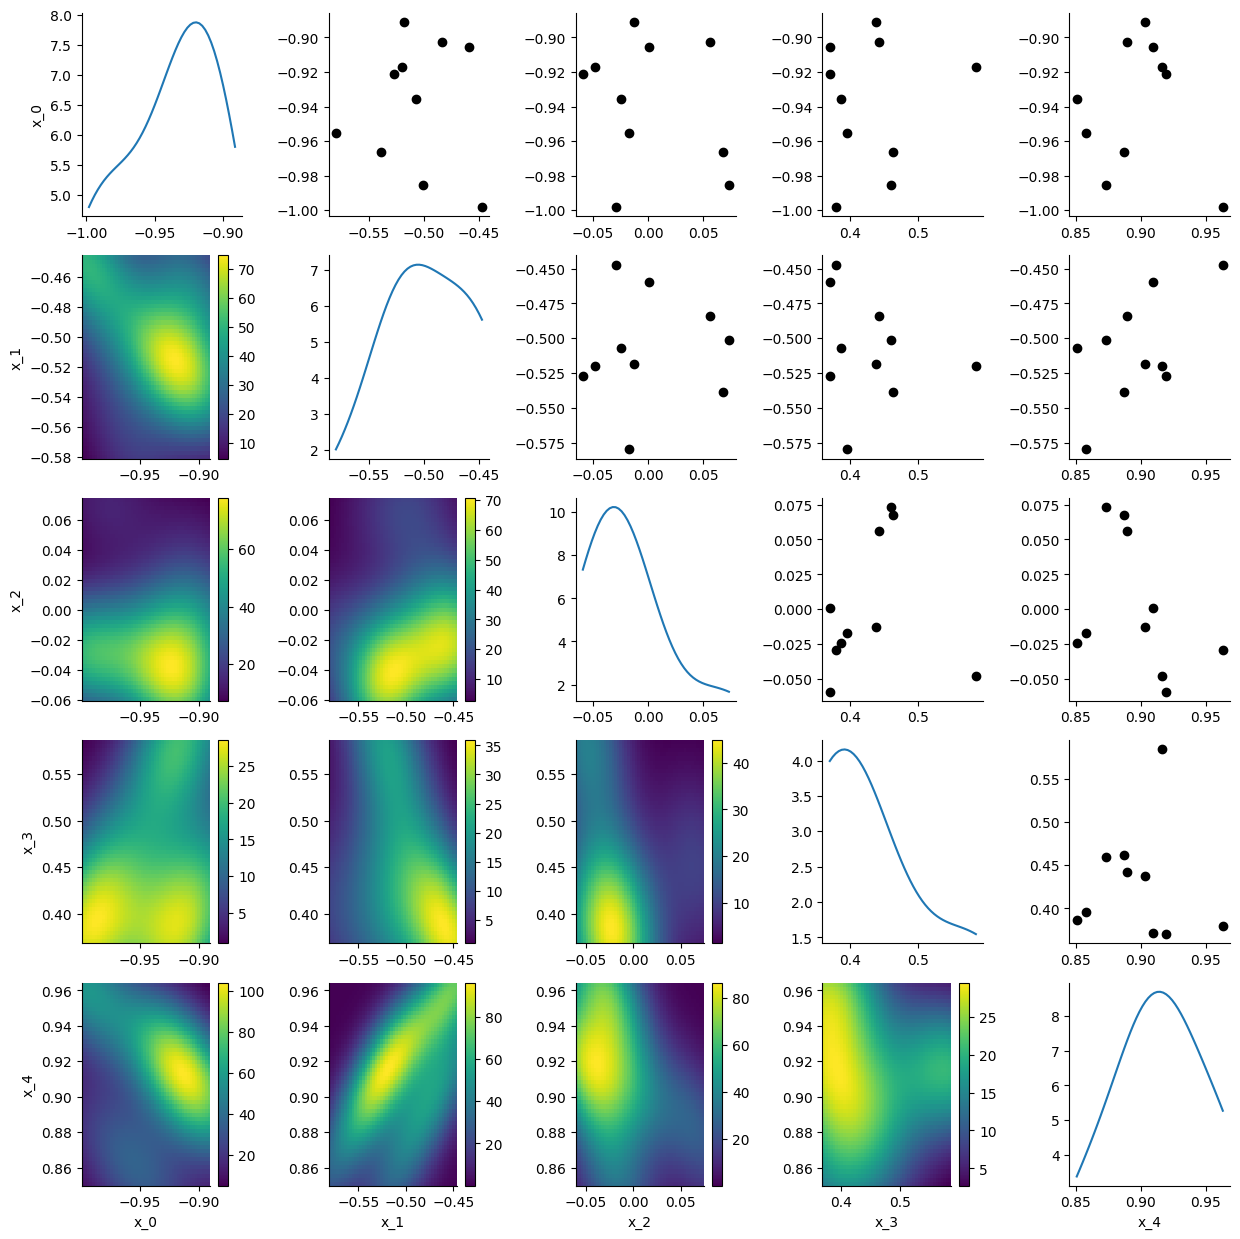

In [31]:
specification = ApproximateBayesianComputationMethodModel(
	experiment_name="pyabc_approximate_bayesian_computation",
	parameter_spec=parameter_spec,
	observed_data=observed_df.y.values,
	n_init=20,
	walltime=5,  # minutes
	epsilon=1,
	output_labels=["y"],
	n_bootstrap=20,
	min_population_size=20,
	verbose=True,
	batched=False,
    random_seed=100,
	method_kwargs=dict(
		max_total_nr_simulations=700, max_nr_populations=20, min_acceptance_rate=0.0
	),
)

calibrator = ApproximateBayesianComputationMethod(
	calibration_func=abc_func, specification=specification, engine="pyabc"
)

calibrator.specify().execute().analyze()

In the plots above, we can see the number of samples taken over our generations.

We also see that epsilon is adaptive, and algorithmically decreases over generations. 

The effective sample size (ESS) is a useful metric for determining how many independent samples you have taken. For sequential Monte Carlo, it determines the diversity of your samples.

We see the walltime in seconds for our samples. And the acceptance rate for our samples seems to decrease over generations.

Finally, we have our parameter estimates, depicted as density plots. Our parameter estimates seem to be close to the ground-truth values.

In [32]:
abc_df = pd.DataFrame({
    "beta_name": [f"x_{i}" for i in range(p)],
    "beta_estimate": [ 
        model.estimate
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "beta_uncertainty": [ 
        model.uncertainty
        for model in calibrator.get_parameter_estimates().estimates
    ],
    "beta_value": beta_true
})
abc_df

,beta_name,beta_estimate,beta_uncertainty,beta_value
0,x_0,-0.937851,0.036818,-1.0
1,x_1,-0.508238,0.038553,-0.5
2,x_2,0.000684,0.048061,0.0
3,x_3,0.428961,0.065469,0.5
4,x_4,0.897251,0.033043,1.0


We can see that unlike the black-box optimisation example above, which yielded only point estimates, Bayesian calibration provides a measure of uncertainty around the parameter estimates (the posterior mean and standard deviation).

# Plots

Let's take the point estimates from the ABC calibrator, run the forward model using those estimates, then compare them with our observed data.

<Axes: xlabel='observed', ylabel='simulated'>

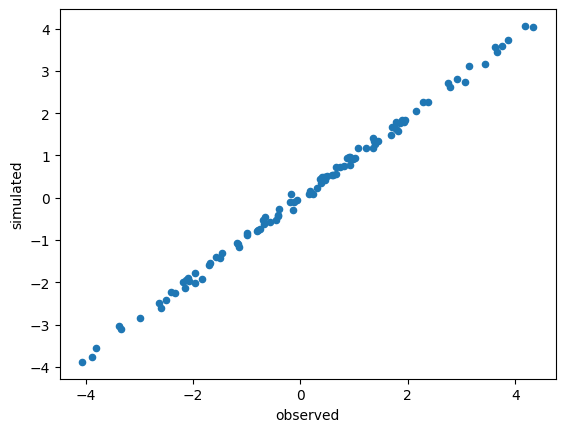

In [51]:
pd.DataFrame({
    "observed": observed_df.y.values,
    "simulated": g(abc_df.beta_estimate.values) + observation_noise
}).plot.scatter("observed", "simulated")

We see a positive diagonal line, suggesting that our predictions are relatively accurate.